<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px;" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png" height="50px"> <a href='https://harvard-iacs.github.io/2021-AC215/' target='_blank'><strong><font color="#A41034">AC215: Advanced Practical Data Science, MLOps</font></strong></a></h1>

# **<font color="#A41034">TF Data & TF Records Tutorial</font>**

**Harvard University**<br/>
**Fall 2021**<br/>
**Instructor:** Pavlos Protopapas<br/>
**Authors:** Shivas Jayaram, Pavlos Protopapas <br>


<hr style="height:2pt">

## **<font color="#A41034">Tutorial Outline</font>**

## **Learning Objectives**

By the end of this notebook, you should be able to:
* Use `tf.data` APIs to build data pipelines for Deep Learning models
* Create TF Records and use them in your model training
* Upload files to a Cloud Storage Bucket 

## **Tutorial Content**

- Download & preview data
- Compute dataset metrics
- Train model using numpy
- Build data pipeline using TF Data
- Train model using TF Data
- Creating TF Records
- Train model using TF Records
- Upload files to Google Cloud Storage

## **<font color="#A41034">Setup Notebook</font>**

**Copy & setup Colab with GPU**

1) Select "File" menu and pick "Save a copy in Drive"  
2) This notebooks is already setup to use GPU but if you want to change it. Go to "Runtime" menu and select "Change runtime type". Then in the popup in "Hardware accelerator" select "GPU" and then click "Save"   
3) If you want high RAM there is an option for that

**Imports**

In [ ]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

# Colab auth
from google.colab import auth
from google.cloud import storage

**Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.6.0
keras version 2.6.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Run this cell to see what GPU you have. If you get a P100 or T4 GPU that's great. If it's K80, it will still work but it will be slow.

In [ ]:
!nvidia-smi

Thu Sep 16 18:41:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    38W / 300W |    427MiB / 16160MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Utils**


Here are some util functions that we will be using for this lab

In [ ]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def get_folder_size(base_path):
  folder_size = subprocess.check_output(['du','-sh', base_path]).split()[0].decode('utf-8')
  return folder_size

# Get Dataset size
def get_dataset_size(base_path):
  dataset_folder_size = get_folder_size(base_path)
  print("Dataset size on disk:")
  print("----------------")
  print("Total Size (Zip + Extracted): ",dataset_folder_size)
  size_type = ""
  if dataset_folder_size.endswith("M"):
    size_type = "MB"
    dataset_folder_size = dataset_folder_size.replace("M","000000")
  elif dataset_folder_size.endswith("G"):
    size_type = "GB"
    dataset_folder_size = dataset_folder_size.replace("G","000000000")
  
  dataset_folder_size = float(dataset_folder_size)

  dataset_file_list = glob(base_path+'/*')
  dataset_download_size = 0.0
  for file in dataset_file_list:
    if file.endswith(".zip"):
      dataset_download_size += os.path.getsize(file)

  dataset_size = dataset_folder_size - dataset_download_size

  if size_type == "MB":
    dataset_download_size = dataset_download_size/1000000
    dataset_size = dataset_size/1000000
  elif size_type == "GB":
    dataset_download_size = dataset_download_size/1000000000
    dataset_size = dataset_size/1000000000

  print("Download Size (Zip): ",str(round(dataset_download_size,4))+size_type)
  print("Dataset Size (Extracted): ",str(round(dataset_size,4))+size_type)

def compute_dataset_metrics(dataset_list):
  data_list_with_metrics = []
  for item in data_list:
    # Read image
    image = cv2.imread(item[1])
    data_list_with_metrics.append((item[0],item[1],image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'label': data_list_with_metrics[:, 0], 
    'path': data_list_with_metrics[:, 1],
    'height': data_list_with_metrics[:, 2],
    'width': data_list_with_metrics[:, 3],
    'size': data_list_with_metrics[:, 4],
    })
  
  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  value_counts = dataset_df["label"].value_counts()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Label Counts:")
  print(value_counts)
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

def sizeof_fmt(num, suffix='B'):
    for unit in ['','K','M','G','T','P','E','Z']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def display_memory_usage(variables, top_n=10):
  variables_size = [(name, sys.getsizeof(value)) for name, value in variables]
  total_size = sum([itm[1] for itm in variables_size]) 
  # top n
  variables_size = sorted((variables_size),key= lambda x: -x[1])[:top_n]
  
  for name, size in variables_size:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
  
  # Total
  print("{:>30}{:>8}".format("------------", "------------"))
  print("{:>30}: {:>8}".format("Total:", sizeof_fmt(total_size)))

def evaluate_model(model,test_data, training_results):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  if type(test_data) is tuple:
    evaluation_results = model.evaluate(test_data[0],test_data[1])
  else:
    evaluation_results = model.evaluate(test_data)
  print(evaluation_results)

## **<font color="#A41034">Dataset</font>**

#### **Download**

In [ ]:
start_time = time.time()
download_file("https://github.com/dlops-io/datasets/releases/download/v1.0/mushrooms_3_labels.zip", base_path="datasets", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.1622810920079549


### **Load Data**

* Read-in data as lists.
* Each element in data_x is the path to the image
* Each element in data_y is the label of that image

In [ ]:
base_path = os.path.join("datasets","mushrooms")
label_names = os.listdir(base_path)
print("Labels:", label_names)

image_width = 224
image_height = 224
num_channels = 3

# Number of unique labels
num_classes = len(label_names) 
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

# Generate a list of labels and path to images
data_list = []
for label in label_names:
  # Images
  image_files = os.listdir(os.path.join(base_path,label))
  data_list.extend([(label,os.path.join(base_path,label,f)) for f in image_files])

print("Full size of the dataset:",len(data_list))
print("data_list:",data_list[:5])

Labels: ['crimini', 'oyster', 'amanita']
Full size of the dataset: 1643
data_list: [('crimini', 'datasets/mushrooms/crimini/200.jpg'), ('crimini', 'datasets/mushrooms/crimini/277.jpg'), ('crimini', 'datasets/mushrooms/crimini/71.jpg'), ('crimini', 'datasets/mushrooms/crimini/417.jpg'), ('crimini', 'datasets/mushrooms/crimini/233.jpg')]


### **View Images**

Let's take a look at the data.

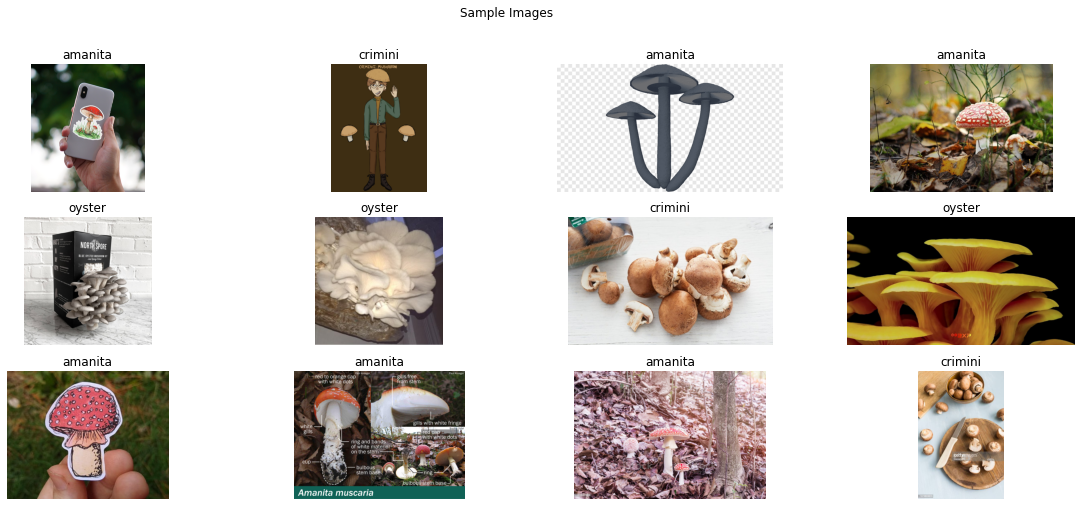

In [ ]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(data_list)-1, size=12)

fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(3,4,i+1)
    axs.set_title(data_list[img_idx][0])
    # Read image
    image = cv2.imread(data_list[img_idx][1])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

### **Dataset Metrics**

Some of the metrics to look into when looking an image dataset:
- Total size on disk
- Total size on memory
- Number of image
- Number of labels
- Are labels imbalanced (Determines if we need to use weighted loss or not)
- Mean, standard deviation of the dataset
- Maximum, minimum, average image size in the dataset
- Dataset size in memory based on various image sizes 

In [ ]:
# Get the size of data in disk
get_dataset_size("datasets")

Dataset size on disk:
----------------
Total Size (Zip + Extracted):  733M
Download Size (Zip):  379.732MB
Dataset Size (Extracted):  353.268MB


In [ ]:
# Compute dataset metrics
compute_dataset_metrics(data_list)

In [ ]:
# Get memory usage of local variables
display_memory_usage(locals().items())

Next let us load the images in store in an array `data_x` and long with the labels in `data_y`

In [ ]:
# Build data x, y
data_x = []
data_y = []
total_images_size = 0

start_time = time.time()
# Load Train/validate data
for label,file_path in data_list:
  # read image
  image = cv2.imread(file_path)
  # convert to rgb
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Keep track of size
  total_images_size += image.nbytes / (1024 * 1024.0)
  
  # Resize image
  image = cv2.resize(image, (image_width,image_height), interpolation = cv2.INTER_AREA)

  # Train x
  data_x.append(image)
  # Train y
  data_y.append([label2index[label]])
  
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

Execution time (mins) 0.6001204729080201


In [ ]:
print("Total image size (not resized):",total_images_size,"MB")

Total image size (not resized): 4580.158979415894 MB


In [ ]:
# Number of times to duplicate the data 
NUM_DUPS = 1

# Convert to numpy array
train_validate_x = np.asarray(data_x*NUM_DUPS)
train_validate_y = np.asarray(data_y*NUM_DUPS)
print("train_validate_x shape:",train_validate_x.shape)
print("train_validate_y shape:",train_validate_y.shape)
print("\n")

# Get memory usage of local variables
display_memory_usage(locals().items())

train_validate_x shape: (1643, 224, 224, 3)
train_validate_y shape: (1643, 1)


              train_validate_x: 235.9 MB
                         image: 147.1 KB
                     data_list:  14.6 KB
                        data_x:  14.3 KB
                        data_y:  14.3 KB
              train_validate_y:  12.9 KB
                           _i4:   5.1 KB
                   image_files:   4.7 KB
                         Model:   1.0 KB
                    Sequential:   1.0 KB
                  ------------------------
                        Total:: 236.1 MB


```
              NUM_DUPS = 1
              train_validate_x: 235.9 MiB
                         image: 147.1 KiB
                     data_list: 14.6 KiB
                        data_x: 14.3 KiB
                        data_y: 14.3 KiB
              train_validate_y: 12.9 KiB
                   image_files:  4.7 KiB
                          _i26:  4.1 KiB
                          _i28:  4.1 KiB
                          _i24:  4.0 KiB
                  ------------------------
                        Total:: 236.1 MiB
```

In [ ]:
# Number of times to duplicate the data 
NUM_DUPS = 10

# Convert to numpy array
train_validate_x = np.asarray(data_x*NUM_DUPS)
train_validate_y = np.asarray(data_y*NUM_DUPS)
print("train_validate_x shape:",train_validate_x.shape)
print("train_validate_y shape:",train_validate_y.shape)
print("\n")

# Get memory usage of local variables
display_memory_usage(locals().items())

train_validate_x shape: (16430, 224, 224, 3)
train_validate_y shape: (16430, 1)


              train_validate_x:   2.3 GB
                         image: 147.1 KB
              train_validate_y: 128.5 KB
                     data_list:  14.6 KB
                        data_x:  14.3 KB
                        data_y:  14.3 KB
                           _i4:   5.1 KB
                   image_files:   4.7 KB
                         Model:   1.0 KB
                    Sequential:   1.0 KB
                  ------------------------
                        Total::   2.3 GB


```
              NUM_DUPS = 10
              train_validate_x:  2.3 GiB
                         image: 147.1 KiB
              train_validate_y: 128.5 KiB
                     data_list: 14.6 KiB
                        data_x: 14.3 KiB
                        data_y: 14.3 KiB
                   image_files:  4.7 KiB
                          _i26:  4.1 KiB
                          _i28:  4.1 KiB
                          _i24:  4.0 KiB
                  ------------------------
                        Total::  2.3 GiB
```

In [ ]:
# # Number of times to duplicate the data 
# NUM_DUPS = 30

# # Convert to numpy array
# train_validate_x = np.asarray(data_x*NUM_DUPS)
# train_validate_y = np.asarray(data_y*NUM_DUPS)
# print("train_validate_x shape:",train_validate_x.shape)
# print("train_validate_y shape:",train_validate_y.shape)
# print("\n")

# # Get memory usage of local variables
# display_memory_usage(locals().items())

```
              NUM_DUPS = 30
              train_validate_x:  6.9 GiB
              train_validate_y: 385.2 KiB
                         image: 147.1 KiB
                     data_list: 14.6 KiB
                        data_x: 14.3 KiB
                        data_y: 14.3 KiB
                   image_files:  4.7 KiB
                           _i4:  4.1 KiB
                         Model:  1.0 KiB
                    Sequential:  1.0 KiB
                  ------------------------
                        Total::  6.9 GiB
```

In [ ]:
# # Number of times to duplicate the data 
# NUM_DUPS = 40

# # Convert to numpy array
# train_validate_x = np.asarray(data_x*NUM_DUPS)
# train_validate_y = np.asarray(data_y*NUM_DUPS)
# print("train_validate_x shape:",train_validate_x.shape)
# print("train_validate_y shape:",train_validate_y.shape)
# print("\n")

# # Get memory usage of local variables
# display_memory_usage(locals().items())

**If you run this cell: Your notebook session will crash after using up all available RAM**

## **<font color="#A41034">Model</font>**

Here will build a simple two block CNN model to test out training our datasets.

In [ ]:
# Build Model
def build_simple_cnn_model(image_height, image_width, num_channels, num_classes):
  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels
  model_input = keras.Input(shape=input_shape)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model_input)
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Flatten
  hidden = keras.layers.Flatten()(hidden)

  #  Hidden Layer, Classification Block
  hidden = keras.layers.Dense(units=64, activation='relu')(hidden)
  hidden = keras.layers.Dense(units=64, activation='relu')(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(model_input, output, name='simple_cnn_model')

  return model

## **<font color="#A41034">Train using numpy</font>**

In [ ]:
# Convert to numpy array
train_validate_x = np.asarray(data_x)
train_validate_y = np.asarray(data_y)
print("train_validate_x shape:",train_validate_x.shape)
print("train_validate_y shape:",train_validate_y.shape)
print("\n")

# Get memory usage of local variables
display_memory_usage(locals().items())

train_validate_x shape: (1643, 224, 224, 3)
train_validate_y shape: (1643, 1)


              train_validate_x: 235.9 MB
                         image: 147.1 KB
                     data_list:  14.6 KB
                        data_x:  14.3 KB
                        data_y:  14.3 KB
              train_validate_y:  12.9 KB
                           _i4:   5.1 KB
                   image_files:   4.7 KB
                            _i:   1.3 KB
                          _i17:   1.3 KB
                  ------------------------
                        Total:: 236.1 MB


In [ ]:
# Perform data pre processing
validation_percent = 0.2

# Split data into train / validation
train_processed_x, validate_processed_x, train_processed_y, validate_processed_y = train_test_split(train_validate_x, train_validate_y, test_size=validation_percent) 

# Normalization values to range between 0 and 1
train_processed_x = train_processed_x.astype("float")/255.0
validate_processed_x = validate_processed_x.astype("float")/255.0

# Converts y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')

print("Inputs x:")
print("train_processed_x shape:",train_processed_x.shape)
print("validate_processed_x shape:",validate_processed_x.shape)
print("Outputs y:")
print("train_processed_y shape:",train_processed_y.shape)
print("validate_processed_y shape:",validate_processed_y.shape)

Inputs x:
train_processed_x shape: (1314, 224, 224, 3)
validate_processed_x shape: (329, 224, 224, 3)
Outputs y:
train_processed_y shape: (1314, 3)
validate_processed_y shape: (329, 3)


Model: "simple_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)  

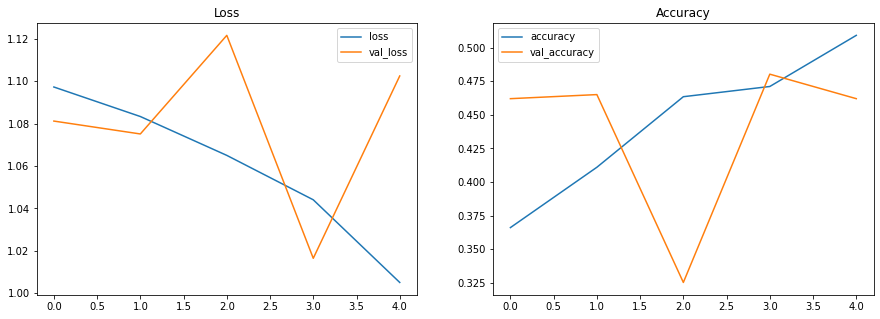

11/11 [==============================] - 0s 22ms/step - loss: 1.1025 - accuracy: 0.4620
[1.102489709854126, 0.4620060920715332]


In [ ]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 5

# Free up memory
K.clear_session()

# Build the model
model = build_simple_cnn_model(image_height, image_width, num_channels, num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum = 0.001)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_processed_x,
        train_processed_y,
        validation_data=(validate_processed_x,validate_processed_y),
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_model(model,(validate_processed_x,validate_processed_y), training_results)

In [ ]:
# Delete variables from memory
del train_processed_x
del validate_processed_x
del train_processed_y
del validate_processed_y
del train_validate_x
del train_validate_y

display_memory_usage(locals().items())

                         image: 147.1 KB
                     data_list:  14.6 KB
                        data_x:  14.3 KB
                        data_y:  14.3 KB
                           _i4:   5.1 KB
                   image_files:   4.7 KB
                          _i17:   1.3 KB
                         Model:   1.0 KB
                    Sequential:   1.0 KB
                           _i2:   1.0 KB
                  ------------------------
                        Total:: 222.8 KB


## **<font color="#A41034">Build Data Pipelines</font>**

### **Load Data** 
Let us replicate the data to simulate a very large dataset

In [ ]:
pavloslist ['cool']

In [ ]:
# Replicate n times
NUM_DUPS = 50
large_data_list = data_list * NUM_DUPS

# Build data x, y
data_x = [itm[1] for itm in large_data_list]
data_y = [itm[0] for itm in large_data_list]

print("data_list:",len(data_list))
print("data_x:",len(data_x))
print("data_y:",len(data_y))
print("data_x:",data_x[:5])
print("data_y:",data_y[:5])

data_list: 1643
data_x: 82150
data_y: 82150
data_x: ['datasets/mushrooms/crimini/200.jpg', 'datasets/mushrooms/crimini/277.jpg', 'datasets/mushrooms/crimini/71.jpg', 'datasets/mushrooms/crimini/417.jpg', 'datasets/mushrooms/crimini/233.jpg']
data_y: ['crimini', 'crimini', 'crimini', 'crimini', 'crimini']


In [ ]:
# Get memory usage of local variables
display_memory_usage(locals().items())

                        data_x: 715.6 KB
                        data_y: 715.6 KB
               large_data_list: 641.9 KB
                         image: 147.1 KB
                     data_list:  14.6 KB
                           _i4:   5.1 KB
                   image_files:   4.7 KB
                          _i17:   1.3 KB
                         Model:   1.0 KB
                    Sequential:   1.0 KB
                  ------------------------
                        Total::   2.2 MB


### **Split Data** 
We split data into train, validation

In [ ]:
validation_percent = 0.2

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, test_size=validation_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))

train_x count: 65720
validate_x count: 16430


### **Create TF Datasets**

From lecture we saw that if we have a large amount of data we need to read them in batches. We will use `tf.data` for this:
<img src="https://storage.googleapis.com/public_colab_images/ai5/tf-data.png" width="1000"/>

In [ ]:
batch_size = 128
train_shuffle_buffer_size = len(train_x)
validation_shuffle_buffer_size = len(validate_x)

# Load Image
def load_image(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.map(load_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(normalize, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(AUTOTUNE)
#train_data = train_data.cache()

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
validation_data = validation_data.map(load_image, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(normalize, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>
validation_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>


In [ ]:
# Get memory usage of local variables
display_memory_usage(locals().items())

                        data_x: 715.6 KB
                        data_y: 715.6 KB
               large_data_list: 641.9 KB
                       train_x: 565.4 KB
                       train_y: 565.4 KB
                         image: 147.1 KB
                    validate_x: 137.3 KB
                    validate_y: 137.3 KB
                     data_list:  14.6 KB
                           _i4:   5.1 KB
                  ------------------------
                        Total::   3.6 MB


<class 'tensorflow.python.framework.ops.EagerTensor'> (128, 224, 224, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'> (128, 3)
[1. 0. 0.]


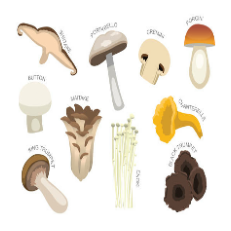

In [ ]:
# View data from tf data
for batch in train_data.take(1):
  image, label = batch

  print(type(image), image.shape)
  print(type(label),label.shape)
  
  # Convert image to numpy
  image = image.numpy()[1]
  label = label.numpy()[1]

  print(label)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

In [ ]:
# Get memory usage of local variables
display_memory_usage(locals().items())

print("Size of train_data:", sys.getsizeof(train_data),"B")
print("Size of validation_data:", sys.getsizeof(validation_data),"B")

                        data_x: 715.6 KB
                        data_y: 715.6 KB
               large_data_list: 641.9 KB
                       train_x: 565.4 KB
                       train_y: 565.4 KB
                    validate_x: 137.3 KB
                    validate_y: 137.3 KB
                     data_list:  14.6 KB
                           _i4:   5.1 KB
                   image_files:   4.7 KB
                  ------------------------
                        Total::   3.4 MB
Size of train_data: 64 B
Size of validation_data: 64 B


## **<font color="#A41034">Train using TF Data</font>**

Model: "simple_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)  

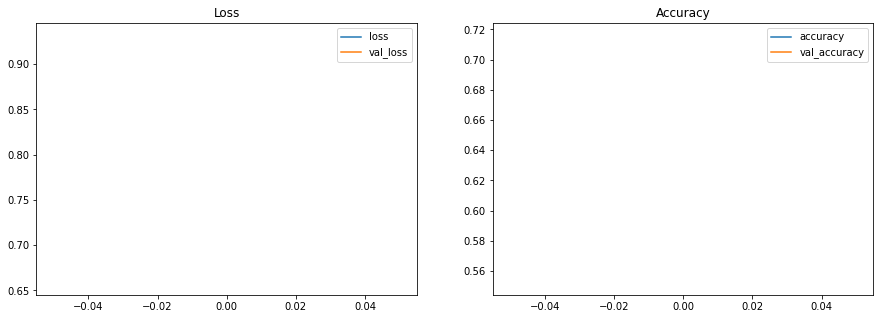

129/129 [==============================] - 119s 926ms/step - loss: 0.6589 - accuracy: 0.7160
[0.6588817834854126, 0.7160072922706604]


In [ ]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 1

# Free up memory
K.clear_session()

# Build the model
model = build_simple_cnn_model(image_height, image_width, num_channels, num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum = 0.001)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_model(model,validation_data, training_results)

## **<font color="#A41034">TF Records</font>**

From lecture we saw that if we have too many image files the number of i/o will slow down our image reading process.
<img src="https://storage.googleapis.com/public_colab_images/ai5/tf-records-1.png" width="800"/>

<br>
<br>

A solution is to bundle multiple images into a compressed binary file called TF Record. Each TF Record file is called a shard.
<img src="https://storage.googleapis.com/public_colab_images/ai5/tf-records-2.png" width="800"/>



### **TFRecords Utils** 
Let us create some util functions to help create TF records

In [ ]:
def create_tf_example(item):

  # Read image
  image = tf.io.read_file(item[1])
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  # # Encode
  # image = tf.cast(image, tf.uint8)
  # image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  image = tf.cast(image, tf.uint8)

  # Label
  label = label2index[item[0]]

  # Build feature dict
  feature_dict = {
      'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.numpy().tobytes()])),
      'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
  }

  example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
  return example

def create_tf_records(data,num_shards=10, prefix='', folder='data'):
  num_records = len(data)
  step_size = num_records//num_shards + 1

  for i in range(0, num_records, step_size):
    print("Creating shard:",(i//step_size)," from records:",i,"to",(i+step_size))
    path = '{}/{}_000{}.tfrecords'.format(folder, prefix, i//step_size)
    print(path)

    # Write the file
    with tf.io.TFRecordWriter(path) as writer:
      # Filter the subset of data to write to tfrecord file
      for item in data[i:i+step_size]:
        tf_example = create_tf_example(item)
        writer.write(tf_example.SerializeToString()) 

### **Test TFRecords Creation** 


#### Create TFRecords

In [ ]:
# Create an output path to store the tfrecords
tfrecords_output_dir = "test_tfrecords"
if os.path.exists(tfrecords_output_dir):
  shutil.rmtree(tfrecords_output_dir)
tf.io.gfile.makedirs(tfrecords_output_dir)

# Take a subset of images
subset_data = large_data_list[:256]
num_shards = 2

# Create TFRecords
create_tf_records(subset_data,num_shards=num_shards, prefix="test", folder=tfrecords_output_dir)

Creating shard: 0  from records: 0 to 129
test_tfrecords/test_0000.tfrecords
Creating shard: 1  from records: 129 to 258
test_tfrecords/test_0001.tfrecords


#### Load TF Data from TFRecords

In [ ]:
batch_size = 128

# Read TF Records
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}
# @tf.function
def parse_tfrecord_example(example_proto):
  parsed_example = tf.io.parse_single_example(example_proto, feature_description)

  # Image
  #image = tf.image.decode_jpeg(parsed_example['image'])
  image = tf.io.decode_raw(parsed_example['image'], tf.uint8)
  image.set_shape([num_channels * image_height * image_width])
  image = tf.reshape(image, [image_height, image_width, num_channels])

  # Label
  label = tf.cast(parsed_example['label'], tf.int32)
  label = tf.one_hot(label, num_classes)

  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

# Create TF Dataset
sample_dataset = tf.data.Dataset.list_files(tfrecords_output_dir+'/*')
sample_dataset = sample_dataset.flat_map(tf.data.TFRecordDataset)
sample_dataset = sample_dataset.map(parse_tfrecord_example, num_parallel_calls=AUTOTUNE)
sample_dataset = sample_dataset.map(normalize, num_parallel_calls=AUTOTUNE)
sample_dataset = sample_dataset.batch(batch_size)
sample_dataset = sample_dataset.prefetch(buffer_size=AUTOTUNE)
print(sample_dataset)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>


#### View TFRecord Example

<class 'tensorflow.python.framework.ops.EagerTensor'> (128, 224, 224, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'> (128, 3)
[1. 0. 0.]


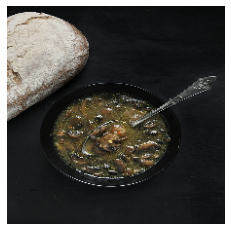

In [ ]:
# View data from TFRecord
for batch in sample_dataset.take(1):
  image, label = batch

  print(type(image), image.shape)
  print(type(label),label.shape)

  # Convert image to numpy
  image = image.numpy()[0]
  label = label.numpy()[0]

  print(label)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

### **TFRecords for entire dataset** 

#### Split Data

In [ ]:
validation_percent = 0.2

# Split data into train / validate
train_xy, validate_xy = train_test_split(large_data_list, test_size=validation_percent)

print("train_xy count:",len(train_xy))
print("validate_xy count:",len(validate_xy))

train_xy count: 65720
validate_xy count: 16430


#### Create TFRecords

In [ ]:
# Create an output path to store the tfrecords
tfrecords_output_dir = "mushroom_tfrecords"
if os.path.exists(tfrecords_output_dir):
  shutil.rmtree(tfrecords_output_dir)
tf.io.gfile.makedirs(tfrecords_output_dir)

# Split data into multiple TFRecord shards between 100MB to 200MB
num_shards = 12

# Create TF Records for train
start_time = time.time()
create_tf_records(train_xy,num_shards=num_shards, prefix="train", folder=tfrecords_output_dir)
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

# Split data into multiple TFRecord shards between 100MB to 200MB
num_shards = 4

# Create TF Records for validation
start_time = time.time()
create_tf_records(validate_xy,num_shards=num_shards, prefix="val", folder=tfrecords_output_dir)
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

Creating shard: 0  from records: 0 to 5477
mushroom_tfrecords/train_0000.tfrecords
Creating shard: 1  from records: 5477 to 10954
mushroom_tfrecords/train_0001.tfrecords
Creating shard: 2  from records: 10954 to 16431
mushroom_tfrecords/train_0002.tfrecords
Creating shard: 3  from records: 16431 to 21908
mushroom_tfrecords/train_0003.tfrecords
Creating shard: 4  from records: 21908 to 27385
mushroom_tfrecords/train_0004.tfrecords
Creating shard: 5  from records: 27385 to 32862
mushroom_tfrecords/train_0005.tfrecords
Creating shard: 6  from records: 32862 to 38339
mushroom_tfrecords/train_0006.tfrecords
Creating shard: 7  from records: 38339 to 43816
mushroom_tfrecords/train_0007.tfrecords
Creating shard: 8  from records: 43816 to 49293
mushroom_tfrecords/train_0008.tfrecords
Creating shard: 9  from records: 49293 to 54770
mushroom_tfrecords/train_0009.tfrecords
Creating shard: 10  from records: 54770 to 60247
mushroom_tfrecords/train_00010.tfrecords
Creating shard: 11  from records: 60

In [ ]:
print("TFRecord folder size:", get_folder_size(tfrecords_output_dir))

TFRecord folder size: 12G


Ideally you would create TFRecords once and save it in some cloud storage so your entire team can access this data and use it for individual model training experiments

## **<font color="#A41034">Train using TFRecords</font>**

#### Load TFRecords

In [ ]:
batch_size = 128

# Read TF Records
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}

# @tf.function
def parse_tfrecord_example(example_proto):
  parsed_example = tf.io.parse_single_example(example_proto, feature_description)

  # Image
  #image = tf.image.decode_jpeg(parsed_example['image'])
  image = tf.io.decode_raw(parsed_example['image'], tf.uint8)
  image.set_shape([num_channels * image_height * image_width])
  image = tf.reshape(image, [image_height, image_width, num_channels])
  # Label
  label = tf.cast(parsed_example['label'], tf.int32)
  label = tf.one_hot(label, num_classes)

  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

# Read the tfrecord files
train_tfrecord_files = tf.data.Dataset.list_files(tfrecords_output_dir+'/train*')
validate_tfrecord_files = tf.data.Dataset.list_files(tfrecords_output_dir+'/val*')

#############
# Train data
#############
train_data = train_tfrecord_files.flat_map(tf.data.TFRecordDataset)
train_data = train_data.map(parse_tfrecord_example, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(normalize, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

##################
# Validation data
##################
validation_data = validate_tfrecord_files.flat_map(tf.data.TFRecordDataset)
validation_data = validation_data.map(parse_tfrecord_example, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(normalize, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>
validation_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>


#### Train

Model: "simple_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)  

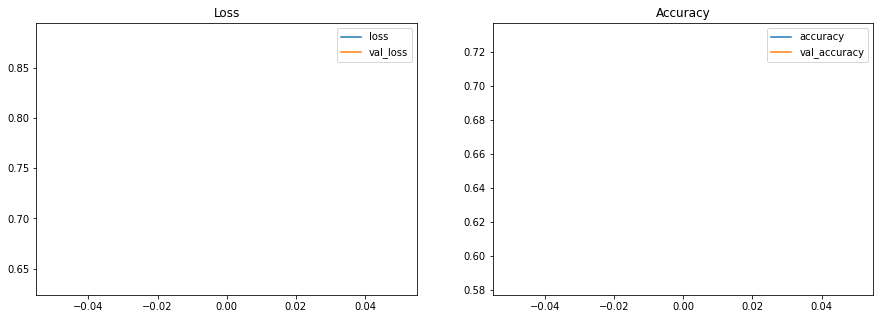

129/129 [==============================] - 9s 67ms/step - loss: 0.6363 - accuracy: 0.7299
[0.6362690329551697, 0.7299452424049377]


In [ ]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 1

# Free up memory
K.clear_session()

# Build the model
model = build_simple_cnn_model(image_height, image_width, num_channels, num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum = 0.001)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_model(model,validation_data, training_results)

## **<font color="#A41034">Upload to Cloud Storage</font>**

In this section we will upload the sample TF records we created into the  AC215 Bucket in Google Cloud Platform (GCP)

### **Check Access to Bucket**

Login using any Google Account

In [ ]:
# Authenticate
auth.authenticate_user()

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=ovVI8liGSevAZYLcO2YmpH6mvrJah4&prompt=consent&access_type=offline&code_challenge=kotxHUSA1OGW9xNqREOUaTtL_IYHHX-Z5pAWlxBtmGY&code_challenge_method=S256

Enter verification code: 4/1AX4XfWj7TAdSdNME9N1C4Al8-xIXRfjmL2Y2_aF81zzT924EOIFLoc_Ak5I


Let's check the user account

In [ ]:
# Check the logged in account
user_account = !gcloud config get-value account
user_account = user_account[0]
print("user_account",user_account)

user_account protopapas@gmail.com


Next check if we have access to upload a test file to the bucket

In [ ]:
# Check Bucket Access
bucket_name = "ac215-test-bucket" # BUCKET NAME

# List buckets in a GCP project
storage_client = storage.Client(project="ac215-project") # PROJECT ID 
# buckets = list(storage_client.list_buckets())
# print(buckets)

# Get bucket for Experiments
bucket = storage_client.get_bucket(bucket_name)
print("Experiments Bucket:",bucket)

# Test Write access
test_file = "test-access-"+user_account+".txt"
with open(test_file, "w") as f:
  f.write(user_account+" has access!")

blob = bucket.blob(test_file) 
print('Uploading file', test_file)
blob.upload_from_filename(test_file)

# List contents of s bucket
blobs = bucket.list_blobs(prefix="", delimiter="/")
for blob in blobs:
  print(blob)

Experiments Bucket: <Bucket: ac215-test-bucket>
Uploading file test-access-protopapas@gmail.com.txt
<Blob: ac215-test-bucket, test-access-ghew@g.harvard.edu.txt, 1631754702676000>
<Blob: ac215-test-bucket, test-access-protopapas@gmail.com.txt, 1631817551972497>
<Blob: ac215-test-bucket, test-access-shivasj@gmail.com.txt, 1631737602150834>


### **Upload to Bucket**

Here we will upload the sample TF Records into the bucket. This is a good way to save our work when running things in Colab so we can share models, data, etc. with team memebers or even other programs that could use your model or data

In [ ]:
# Copy the sample tf records to GCP Bucket
for file_path in glob(tfrecords_output_dir+'/*'):
  print(file_path)
  blob = bucket.blob(os.path.join(user_account, file_path)) 
  print('uploading file', file_path)
  blob.upload_from_filename(file_path)

mushroom_tfrecords/train_0000.tfrecords
uploading file mushroom_tfrecords/train_0000.tfrecords
mushroom_tfrecords/val_0001.tfrecords
uploading file mushroom_tfrecords/val_0001.tfrecords
mushroom_tfrecords/train_0006.tfrecords
uploading file mushroom_tfrecords/train_0006.tfrecords
